# Learning the dynamics of PDEs with LDNet (Test Case 1b)

This notebook contains a tutorial with an example of usage of an LDNet to learn the dynamics underlying the following Diffusion-Reaction equation (Test case 1b, Section 3.1.3 of the Supplementary Information):
$$
\begin{cases}
\frac{\partial z(x,t)}{\partial t} - \mu_1 \frac{\partial^2 z(x,t)}{\partial x^2} + \mu_3 z(x,t) = A(t) \cos(\pi x − P(t)), & x \in (-1,1), t\in (0,T], \\
z(-1,t) = z(1,t) & t\in (0,T], \\
z(x,0)= 0 & x \in (-1,1).
\end{cases}
$$
with parameters $\mu_1 = 0.05$ and $\mu_3 = 0.02$. The LDNet is trained in order to predict the space-time dynamics of $z(x,t)$ for a generic input $\mathbf{u}(t) = (A(t), P(t))$.

In [ ]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# We configure TensorFlow to work in double precision 
tf.keras.backend.set_floatx('float64')

import utils
import optimization

### Problem setting

We define the name of the variables of the problem at hand.

In [2]:
problem = {
    'space': {
        'dimension' : 1
    },
    'input_parameters': [],
    'input_signals': [
        { 'name': 'amplitude' },
        { 'name': 'phase' }
    ],
    'output_fields': [
        { 'name': 'z' }
    ]
}

We define, for each variable, a lower and an upper bound to be used to normalize the data.

In [3]:
normalization = {
    'space': { 'min' : [-1], 'max' : [+1]},
    'time': { 'time_constant' : 2.3 },
    'input_signals': {
        'amplitude': { 'min':   0, 'max': 0.8},
        'phase'    : { 'min':  -4, 'max': 4 },
    },
    'output_fields': {
        'z': { 'min': -1, 'max': +1 }
    }
}

We define the time step size and the number of latent variables used by the LDNet.

In [4]:
dt = 5e-2
num_latent_states = 2

### Datasets

We load training, validation and testing data. Here, training, validation and test sets comprise $n_{\mathrm{samples}} = 100$ samples each.
We resample data points on a regular grid with $n_{\mathrm{times}} = 101$ time instants and $n_{\mathrm{points}} = 100$ space points.
By following the notation of the paper, we denote by $d = 1$ the spatial dimension, by $d_{\mathbf{u}} = 2$ the number of input parameters and by $d_{\mathbf{y}} = 1$ the number of output fields.

Each dataset is stored as a Python dictionary, with the following fields (shape is indicated in square brackets):
- `times` $[n_{\mathrm{times}}]$: time instants;
- `points` $[n_{\mathrm{points}}, d]$: space points;
- `points_full` $[n_{\mathrm{samples}}, n_{\mathrm{times}}, n_{\mathrm{points}}, d]$: space points repeated for each sample and time instant;
- `inp_signals` $[n_{\mathrm{samples}}, n_{\mathrm{times}}, d_{\mathbf{u}}]$: input signals for each sample and time instant;
- `out_fields` $[n_{\mathrm{samples}}, n_{\mathrm{times}}, n_{\mathrm{points}}, d_{\mathbf{y}}]$: output fields for each sample, time instant and space point.

In [ ]:
data_set_path = '../data/ADR/data_1b.npy'
samples_train = np.arange(  0, 100)
samples_valid = np.arange(100, 200)
samples_tests = np.arange(200, 300)

dataset = np.load(data_set_path, allow_pickle = True)[()]
dataset_train = utils.ADR_create_dataset(dataset, samples_train)
dataset_valid = utils.ADR_create_dataset(dataset, samples_valid) 
dataset_tests = utils.ADR_create_dataset(dataset, samples_tests) 

# We re-sample the time transients with timestep dt and we rescale each variable between -1 and 1.
utils.process_dataset(dataset_train, problem, normalization, dt = dt)
utils.process_dataset(dataset_valid, problem, normalization, dt = dt)
utils.process_dataset(dataset_tests, problem, normalization, dt = dt)

### Architecture

We create two fully-connected neural networks of which the LDNet is made up:
- the dynamics network $\mathcal{NN}_{\mathrm{dyn}}$, with two hidden layers of 10 neurons each;
- the reconstruction network $\mathcal{NN}_{\mathrm{rec}}$, with two hidden layers of 7 neurons each.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                50        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 2)                 22        
                                                                 
Total params: 182
Trainable params: 182
Non-trainable params: 0
_________________________________________________________________


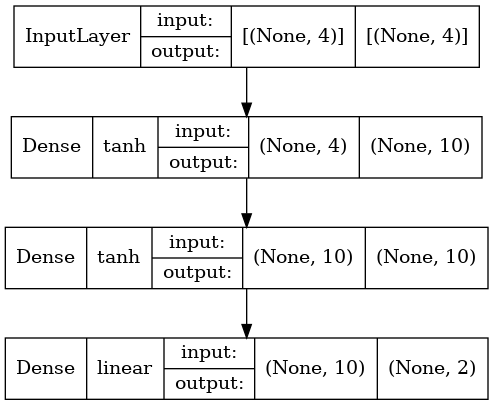

In [6]:
# For reproducibility (delete if you want to test other random initializations)
np.random.seed(0)
tf.random.set_seed(0)

# dynamics network
input_shape = (num_latent_states + len(problem['input_parameters']) + len(problem['input_signals']),)
NNdyn = tf.keras.Sequential([
            tf.keras.layers.Dense(10, activation = tf.nn.tanh, input_shape = input_shape),
            tf.keras.layers.Dense(10, activation = tf.nn.tanh),
            tf.keras.layers.Dense(num_latent_states)
        ])

# summary
NNdyn.summary()

# visualization
tf.keras.utils.plot_model(NNdyn, show_shapes=True, show_layer_names=False, show_layer_activations=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, None, None, 7)     28        
                                                                 
 dense_4 (Dense)             (None, None, None, 7)     56        
                                                                 
 dense_5 (Dense)             (None, None, None, 1)     8         
                                                                 
Total params: 92
Trainable params: 92
Non-trainable params: 0
_________________________________________________________________


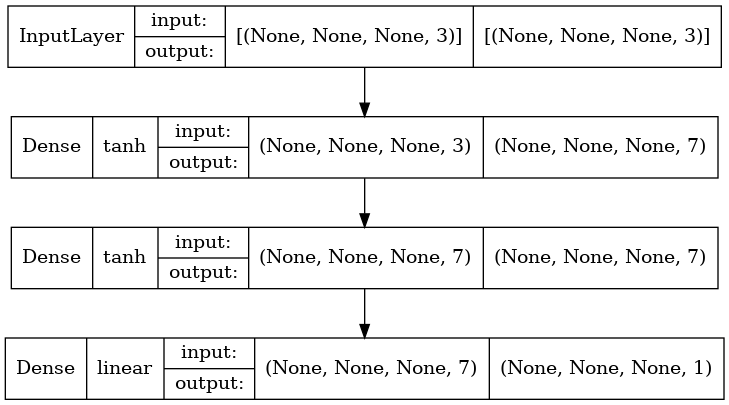

In [7]:
# reconstruction network
input_shape = (None, None, num_latent_states + problem['space']['dimension'])
NNrec = tf.keras.Sequential([
            tf.keras.layers.Dense(7, activation = tf.nn.tanh, input_shape = input_shape),
            tf.keras.layers.Dense(7, activation = tf.nn.tanh),
            tf.keras.layers.Dense(len(problem['output_fields']))
        ])

# summary
NNrec.summary()

# visualization
tf.keras.utils.plot_model(NNrec, show_shapes=True, show_layer_names=False, show_layer_activations=True)

The LDNet action is defined through the following two functions:
- `evolve_dynamics` computes the evolution of the latent states;
- `reconstruct_output` reconstructs the output field from the latent states evolution.

In [8]:
def evolve_dynamics(dataset):
    # intial condition
    state = tf.zeros((dataset['num_samples'], num_latent_states), dtype=tf.float64)
    state_history = tf.TensorArray(tf.float64, size = dataset['num_times'])
    state_history = state_history.write(0, state)
    dt_ref = normalization['time']['time_constant']
    
    # time integration
    for i in tf.range(dataset['num_times'] - 1):
        state = state + dt/dt_ref * NNdyn(tf.concat([state, dataset['inp_signals'][:,i,:]], axis = -1))
        state_history = state_history.write(i + 1, state)

    return tf.transpose(state_history.stack(), perm=(1,0,2))

def reconstruct_output(dataset, states):    
    states_expanded = tf.broadcast_to(tf.expand_dims(states, axis = 2), 
        [dataset['num_samples'], dataset['num_times'], dataset['num_points'], num_latent_states])
    return NNrec(tf.concat([states_expanded, dataset['points_full']], axis = 3))

def LDNet(dataset):
    states = evolve_dynamics(dataset)
    return reconstruct_output(dataset, states)

### Loss function

We define the loss function as the MSE (mean square error) over the whole dataset plus a Tikhonov regularization on the NNs' weights.

In [9]:
def MSE(dataset):
    out_fields = LDNet(dataset)
    error = out_fields - dataset['out_fields']
    return tf.reduce_mean(tf.square(error))

def weights_reg(NN):
    return sum([tf.reduce_mean(tf.square(lay.kernel)) for lay in NN.layers])/len(NN.layers)

alpha_reg = 1e-5
def loss(): return MSE(dataset_train) + alpha_reg * (weights_reg(NNdyn) + weights_reg(NNrec))
def MSE_valid(): return MSE(dataset_valid)

### LDNet training

We train the LDNet with $50$ iterations based on the Adam optimizer, followed by $150$ iterations based on the BFGS optimizer.
Notice that the trainable variables of the LDNet are given as the union of the trainable variables of $\mathcal{NN}_{\mathrm{dyn}}$ and $\mathcal{NN}_{\mathrm{rec}}$.

In [10]:
trainable_variables = NNdyn.variables + NNrec.variables
opt = optimization.OptimizationProblem(trainable_variables, loss, MSE_valid)

num_epochs_Adam = 50
num_epochs_BFGS = 150

print('training (Adam)...')
opt.optimize_keras(num_epochs_Adam, tf.keras.optimizers.Adam(learning_rate=1e-2))
print('training (BFGS)...')
opt.optimize_BFGS(num_epochs_BFGS)

Tracing functions with autograph...


Tracing completed.
epoch    0   -   training loss: 2.880e-01   -   validation loss 2.790e-01
training (Adam)...
epoch   10   -   training loss: 1.230e-01   -   validation loss 1.190e-01
epoch   20   -   training loss: 1.117e-01   -   validation loss 1.091e-01
epoch   30   -   training loss: 1.002e-01   -   validation loss 9.747e-02
epoch   40   -   training loss: 8.622e-02   -   validation loss 8.502e-02
epoch   50   -   training loss: 6.580e-02   -   validation loss 6.780e-02
training (BFGS)...
epoch   60   -   training loss: 3.045e-02   -   validation loss 3.414e-02
epoch   70   -   training loss: 2.163e-02   -   validation loss 2.611e-02
epoch   80   -   training loss: 1.938e-02   -   validation loss 2.318e-02
epoch   90   -   training loss: 1.723e-02   -   validation loss 2.065e-02
epoch  100   -   training loss: 1.536e-02   -   validation loss 1.853e-02
epoch  110   -   training loss: 1.307e-02   -   validation loss 1.594e-02
epoch  120   -   training loss: 1.047e-02   -   validat

We plot the progress of training and validation MSE during the advancement of epochs.

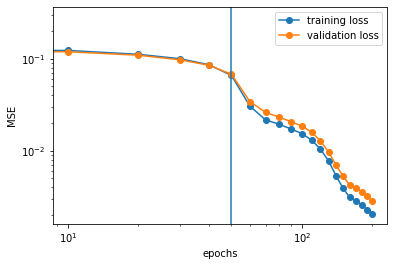

In [11]:
plt.loglog(opt.iterations_history, opt.loss_train_history, 'o-', label = 'training loss')
plt.loglog(opt.iterations_history, opt.loss_valid_history, 'o-', label = 'validation loss')
plt.axvline(num_epochs_Adam)
plt.xlabel('epochs'), plt.ylabel('MSE')
plt.legend()

### Testing

We predict the output field on the testing samples, and we compute error metrics: the normalized root mean square error and the Pearson dissimilarity.

In [12]:
# Compute predictions.
out_fields = LDNet(dataset_tests)

# Since the LDNet works with normalized data, we map back the outputs into the original ranges.
out_fields_app = utils.denormalize_output(out_fields, problem, normalization).numpy()
out_fields_ref = utils.denormalize_output(dataset_tests['out_fields'], problem, normalization).numpy()

NRMSE = np.sqrt(np.mean(np.square(out_fields_app - out_fields_ref))) / (np.max(out_fields_ref) - np.min(out_fields_ref))

import scipy.stats
R_coeff = scipy.stats.pearsonr(np.reshape(out_fields_app, (-1,)), np.reshape(out_fields_ref, (-1,)))

print('Normalized RMSE:       %1.3e' % NRMSE)
print('Pearson dissimilarity: %1.3e' % (1 - R_coeff[0]))

Normalized RMSE:       2.440e-02
Pearson dissimilarity: 1.052e-02


Finally, we show a comparison between 24 samples from the test set and their correspondent LDNet approximation.

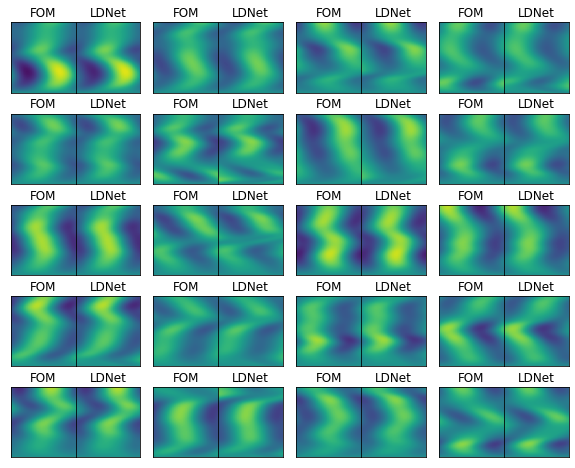

In [14]:
utils.plot_output_1D(dataset_tests, out_fields_ref, out_fields_app, 5, 4, title_ROM = 'LDNet')